In [2]:
# import Pkg; Pkg.add("DataFrames")
using KrylovKit
include("ed.jl")
using .observables

# Perturbation theory vs Mathieu function

For this analysis, consider the Hamiltonian
$$H=-\frac{\partial^2}{\partial \phi^2} + g\cos \phi$$
$$\tilde{H}=\cos \phi-\frac{1}{g}\frac{\partial^2}{\partial \phi^2}$$
The eigenvalue equation for this is
$$\cos \phi \psi-\frac{1}{g}\frac{\partial^2 \psi}{\partial \phi^2}=\tilde{E}\psi=\frac{E}{g}\psi$$
$$\frac{\partial^2 \psi}{\partial \phi^2}+g(\tilde{E}-\cos\phi)\psi=0$$
This is in the form of the Mathieu equation where $q=g/2$ and $a=g\tilde{E}=E$

In [115]:
using MathieuFunctions
using Plots

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))
k_values = []
g_values = 10 .^(0:0.1:9)
for g in g_values
    # println(collect(Iterators.flatten(f(g/2)))[1]/g+1)
    eigenvalue = Complex(collect(Iterators.flatten(f(g/2)))[1]+ g)
    # println(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3)))
    push!(k_values, real(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3))))
end

plot(g_values, k_values, xlabel="g", ylabel="k", dpi=300)

# k=13
# eigenvalues_pt = -1 + 1/(3g)*k*(k+1)*(2k+1)
# println(eigenvalues, " ", eigenvalues_pt)
savefig("tmp.png")

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\tmp.png"

In [1]:
g = 1e8
println(f(g*2)[1]/4/g)
# -10000 + 5*(5+1)/3

UndefVarError: UndefVarError: `f` not defined

# Hessian diagonalization

In [191]:
Nsites = 2
angle = 0
Estrength = 0
g = 10000


10000

In [192]:
using Symbolics
using LinearAlgebra
using IterTools

# numerically diagonalize hamiltonian
@variables x[1:Nsites]
hamiltonian = g*sum(sin(ϕ_1)*sin(ϕ_2) - 2*cos(ϕ_1)*cos(ϕ_2) for (ϕ_1, ϕ_2) in partition(x,2,1))
# hamiltonian = g*sum(ϕ_1*ϕ_2+ϕ_1^2+ϕ_2^2 -2 for (ϕ_1, ϕ_2) in partition(x,2,1))
ground_energy = substitute(hamiltonian, Dict(y => 0 for y in x)).val
a = substitute(Symbolics.hessian(hamiltonian,[x...]), Dict(y => π for y in x))
a = map(x-> x.val, a)

λ, vecs = eigen(a)

eigenvalues2 = []
for n in Tuple.(CartesianIndices(Tuple(0:7 for i=1:Nsites)))
    # vec = (n .+ 1/2) .* sqrt.(2*λ)  .+ ground_energy/Nsites
    # push!(eigenvalues2,\(A, vec)[end])
    push!(eigenvalues2,sum((n .+ 1/2) .* sqrt.(2*λ)) + ground_energy)
end
sort(eigenvalues2)[1:10]

10-element Vector{Any}:
 -19806.814834742185
 -19665.393478504877
 -19561.86586046387
 -19523.97212226757
 -19420.444504226558
 -19382.550766030257
 -19316.91688618555
 -19279.02314798925
 -19241.12940979295
 -19175.495529948243

# Mathieu functions

In [17]:
# comparing the N=2 case with the Mathieu functions
using MathieuFunctions

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))

f (generic function with 1 method)

In [98]:
using LaTeXStrings
using Plots

# pyplot()
function filter_checkerboard(x)
    xlen, ylen = size(x)
    output = zeros(xlen*ylen ÷ 2)
    k = 1
    for i=1:xlen
        for j=1:ylen
            if (i÷2 + (j÷2))%2 == 0
                # println(i," ",j)
                output[k] = x[i,j]
                k += 1
            end
        end
    end 
    return output
end

# ENV["GKS_FONT_DIRS"] = pwd()
# using GR
# font = loadfont("times.ttf")
# settextfontprec(font, GR.TEXT_PRECISION_OUTLINE)

# PyPlot.matplotlib[:rc]("text", usetex=true)
# p = plot(xlabel=L"$g$", ylabel=L"E", legend=nothing, fontfamily="times", dpi=300)
g_values =0:0.01:30
data = reduce(vcat,transpose.([collect(Iterators.flatten(filter_checkerboard(f(g/2) .+ f(3/2*g)') ./2)) for g in g_values]))
data = data[:, sortperm(data[1,:])]
data[20,1:15]
# for i in 1:20
#     plot!(p, g_values, data[:,i])
# end
# display(p)
# savefig("2024_06_13_mathieu_N=2_ed.png")

15-element Vector{Float64}:
 -0.022383172389421443
  0.8045444917540887
  1.089183348622865
  0.8995310975790368
  1.184169954447813
  1.9943627897042562
  2.0144890726609246
  1.9794948281211717
  1.9817488202200808
  3.9962407902148493
  4.0163670731715175
  3.9984947823137587
  4.018621065270427
  4.9543023958765176
  4.954663526259299

In [113]:
g = -0.2
println((charA(3g/2;k=1:1) .+charA(g/2;k=1:1))./2)
println((charA(3g/2;k=1:1) .+ charB(g/2;k=1:1))./2)
println((charB(3g/2;k=1:1) .+ charA(g/2;k=1:1))./2)
println((charB(3g/2;k=1:1) .+ charB(g/2;k=1:1))./2)


[0.7939657463041125]
[0.8939501242886359]
[1.0935445976605989]
[1.1935289756451222]


In [112]:
using MathieuFunctions
g = -0.2

println((charA(3g/2;k=0:1)[1:1] .+charB(g/2;k=2:2))./2)
println((charA(3g/2;k=0:1)[1:1] .+charA(g/2;k=2:2))./2)
println((charB(3g/2;k=2:2) .+ charA(g/2;k=0:1)[1:1])./2)
println((charA(3g/2;k=2:2) .+ charA(g/2;k=0:1)[1:1])./2)


[1.9773003639055893]
[1.9797975924059048]
[1.9937541916220762]
[2.0160336655677447]


In [114]:
println((charB(3g/2;k=2:2) .+ charB(g/2;k=2:2))./2)
println((charB(3g/2;k=2:2) .+ charA(g/2;k=2:2))./2)
println((charA(3g/2;k=2:2) .+ charB(g/2;k=2:2))./2)
println((charA(3g/2;k=2:2) .+charA(g/2;k=2:2))./2)


[3.9958348149383482]
[3.9983320434386638]
[4.018114288884016]
[4.0206115173843315]


In [115]:
g = 1
sort(collect(Iterators.flatten(filter_checkerboard(f(g/2) .+ f(3/2*g)') ./2)))[1:20]

20-element Vector{Float64}:
 -0.5292920195323532
 -0.13130539915481576
  0.36675084463629193
  1.3182971325595956
  1.5211853608138712
  1.5820410507184333
  1.8163533763507034
  1.8462626628111247
  2.3125069615871534
  3.896740043157349
  3.957595733061911
  4.140227342838456
  4.142170887277014
  4.362984341933378
  4.42384003183794
  4.781631387399349
  4.831977701307232
  5.279687631190457
  5.33003394509834
  5.589829874552867

# DVR

In [31]:
mmax = 12
Nsites = 2
angle = 0
Estrength = 0
g = 0.0001
pairs = "nearest"
energies = 15

dimension_parity = "even"
if dimension_parity  == "even"
    dim = 2*mmax
else
    dim = 2*mmax+1
end
initial_state = rand(ComplexF64, dim^Nsites)
H(x) = Hamiltonian_DVR(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs, dimension_parity=dimension_parity)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp

vecs

17-element Vector{Vector{ComplexF64}}:
 [0.029847520440939506 + 0.02907892498045387im, 0.029847418741277495 + 0.02907882589963219im, 0.029847120574328062 + 0.029078535410699im, 0.029846646263427732 + 0.02907807331365021im, 0.02984602813720494 + 0.02907747110462824im, 0.029845308325064632 + 0.02907676982817592im, 0.029844535884766037 + 0.029076017278778912im, 0.029843763458211735 + 0.029075264742772614im, 0.0298430436836217 + 0.0290745635029044im, 0.029842425608693733 + 0.029073961343857407im  …  0.029841846312037804 + 0.02907339696451463im, 0.029842224425476346 + 0.02907376534125577im, 0.029842760062422508 + 0.029074287185159205im, 0.029843416725164985 + 0.02907492693835643im, 0.02984414966742846 + 0.029075641006821393im, 0.02984490894262997 + 0.029076380730132294im, 0.02984564280706186 + 0.02907709569701933im, 0.029846301246234937 + 0.029077737180903212im, 0.02984683938404498 + 0.029078261461271897im, 0.029847220542227423 + 0.029078632804353056im]
 [0.07942091905745141 - 0.02524102379

In [10]:
# inversion_projection_dvr(vecs[energy_level]; Nsites, mmax, parity="odd", direction="LR")
energy_level = 2
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=dim)
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    # println(data/dim*360, " ", abs.(vecs[energy_level][indices][end-i])^2, " ")
    println(data/dim*360, " ", real.(vecs[energy_level][indices][end-i]/vecs[energy_level][indices][end]), " ")
end



[180.0, 180.0] 1.0 
[0.0, 0.0] -0.999999999999989 
[165.0, 180.0] 0.9813150432386271 
[345.0, 0.0] -0.9813150432386144 
[180.0, 195.0] 0.9813150432385921 
[0.0, 15.0] -0.981315043238588 
[180.0, 165.0] 0.9813150432385362 
[0.0, 345.0] -0.9813150432385274 
[15.0, 0.0] -0.9813150432384938 
[195.0, 180.0] 0.9813150432384913 
[165.0, 195.0] 0.9643191486658229 
[345.0, 15.0] -0.9643191486658127 
[15.0, 345.0] -0.9643191486656348 
[195.0, 165.0] 0.9643191486656272 
[165.0, 165.0] 0.9611701621145126 
[345.0, 345.0] -0.9611701621145062 
[15.0, 15.0] -0.9611701621144414 
[195.0, 195.0] 0.9611701621144325 
[150.0, 180.0] 0.92687479245325 
[330.0, 0.0] -0.9268747924532492 
[0.0, 30.0] -0.9268747924531917 


In [77]:
hist_data = zeros(dim, Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=dim)
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

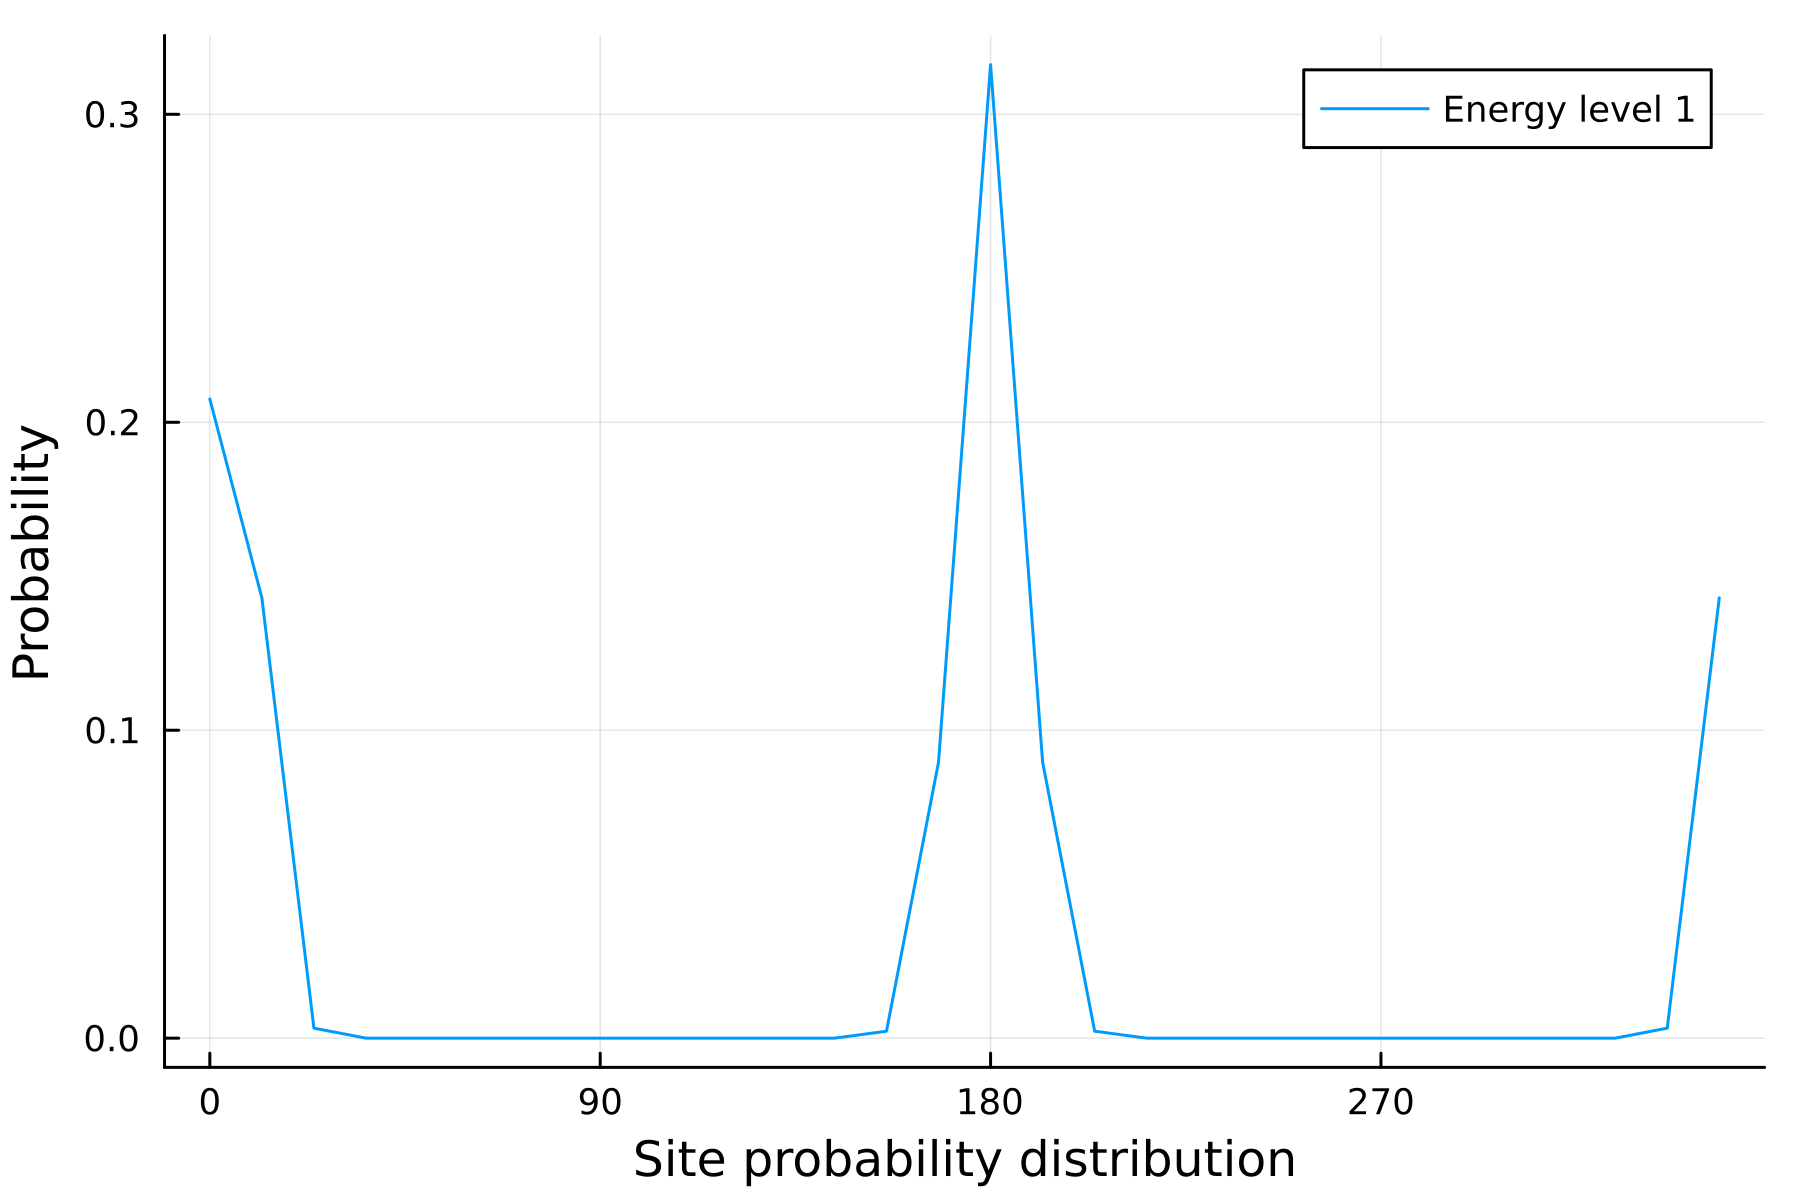

In [78]:
using Plots

# data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",dpi=300, xticks=([0,90,180,270,360]))
for (i,energy_level) in enumerate(1:1)
    data = hist_data[:,2,energy_level]
    # bar!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
    # label=string("Energy level ", energy_level), bar_width = 360/length(data))
    plot!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
        label=string("Energy level ", energy_level))
end
display(p)
# savefig("2024_05_31_single_site2_4_probability_DVR_dist_g=30_mmax=7.png")

In [32]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_reflection = sum(abs.(reflection_projection(vec; Nsites, dim, parity="even").^2))
    even_inversion_dvr = sum(abs.(inversion_projection_dvr(vec; Nsites, dim, parity="even").^2))
    println(@sprintf("%d - energy: %0.3f - reflection (even): %d - inversion_dvr (even): %d", i, real(energy), even_reflection, even_inversion_dvr))
end

1 - energy: -0.000 - reflection (even): 1 - inversion_dvr (even): 1
2 - energy: 1.000 - reflection (even): 1 - inversion_dvr (even): 1
3 - energy: 1.000 - reflection (even): 0 - inversion_dvr (even): 0
4 - energy: 1.000 - reflection (even): 1 - inversion_dvr (even): 0
5 - energy: 1.000 - reflection (even): 0 - inversion_dvr (even): 1
6 - energy: 2.000 - reflection (even): 0 - inversion_dvr (even): 0
7 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 1
8 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 0
9 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 1
10 - energy: 4.000 - reflection (even): 0 - inversion_dvr (even): 1
11 - energy: 4.000 - reflection (even): 1 - inversion_dvr (even): 0
12 - energy: 4.000 - reflection (even): 0 - inversion_dvr (even): 0
13 - energy: 4.000 - reflection (even): 1 - inversion_dvr (even): 1
14 - energy: 5.000 - reflection (even): 0 - inversion_dvr (even): 0
15 - energy: 5.000 - reflection (even): 0 - inversion_dv

# M basis

In [20]:

mmax = 5
Nsites = 2
angle = 0
Estrength = 0

pairs = "nearest"
energies = 20

g = 1
dim = 2*mmax+1
initial_state = rand(ComplexF64, (2*mmax+1)^Nsites)
H(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp
real.(vals)

21-element Vector{Float64}:
 -0.5292920195302895
 -0.13130539914644465
  0.3667508446473521
  1.318297132583549
  1.5211853609343258
  1.582041050837645
  1.8163533763821331
  1.846262662846048
  2.31250696162409
  3.8967400451295693
  ⋮
  4.142170891031885
  4.362984344008078
  4.423840033889195
  4.781631388794016
  4.831977702692503
  5.279687633007096
  5.330033946902449
  5.589829884954273
  5.591773429385929

In [21]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_inversion = Int(round(sum(abs.(inversion_projection_m(vec; Nsites, dim, parity="even").^2))))
    even_reflection = Int(round(sum(abs.(reflection_projection(vec; Nsites, dim, parity="even").^2))))
    even_parity = Int(round(sum(abs.(parity_projection_m(vec; Nsites, dim, parity="even").^2))))
    println(@sprintf("%d - energy: %0.7f - parity (even): %d  - reflection (even): %d - inversion (even): %d", i, real(energy),even_parity,even_reflection, even_inversion ))
end

1 - energy: -0.5292920 - parity (even): 1  - reflection (even): 1 - inversion (even): 1
2 - energy: -0.1313054 - parity (even): 0  - reflection (even): 1 - inversion (even): 1
3 - energy: 0.3667508 - parity (even): 0  - reflection (even): 0 - inversion (even): 0
4 - energy: 1.3182971 - parity (even): 0  - reflection (even): 1 - inversion (even): 0
5 - energy: 1.5211854 - parity (even): 1  - reflection (even): 0 - inversion (even): 0
6 - energy: 1.5820411 - parity (even): 1  - reflection (even): 1 - inversion (even): 1
7 - energy: 1.8163534 - parity (even): 0  - reflection (even): 0 - inversion (even): 1
8 - energy: 1.8462627 - parity (even): 1  - reflection (even): 1 - inversion (even): 0
9 - energy: 2.3125070 - parity (even): 1  - reflection (even): 1 - inversion (even): 1
10 - energy: 3.8967400 - parity (even): 1  - reflection (even): 0 - inversion (even): 1
11 - energy: 3.9575957 - parity (even): 1  - reflection (even): 1 - inversion (even): 0
12 - energy: 4.1402273 - parity (even):

In [17]:
energy_level = 3
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = digits(indices[end - i]-1, base=2*mmax+1, pad=Nsites) .- mmax
    println(data, " ", real.(vecs[energy_level][indices][end-i]/vecs[energy_level][indices][end]))
    # println(data, " ", p[end-i])
end


[0, -1] 1.0
[0, 1] -0.9999999999999978
[1, 0] 0.9999999999999978
[-1, 0] -0.9999999999999957
[-1, -1] 1.6867519750481407e-15
[1, 1] -1.8314148013882183e-15
[1, -1] 2.2922917860801416e-15
[-1, 1] -1.705773300551808e-15
[0, 0] 2.884384933341726e-17


BoundsError: BoundsError: attempt to access 9-element Vector{Int64} at index [0]

In [181]:
hist_data = zeros(Int(2*mmax+1), Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

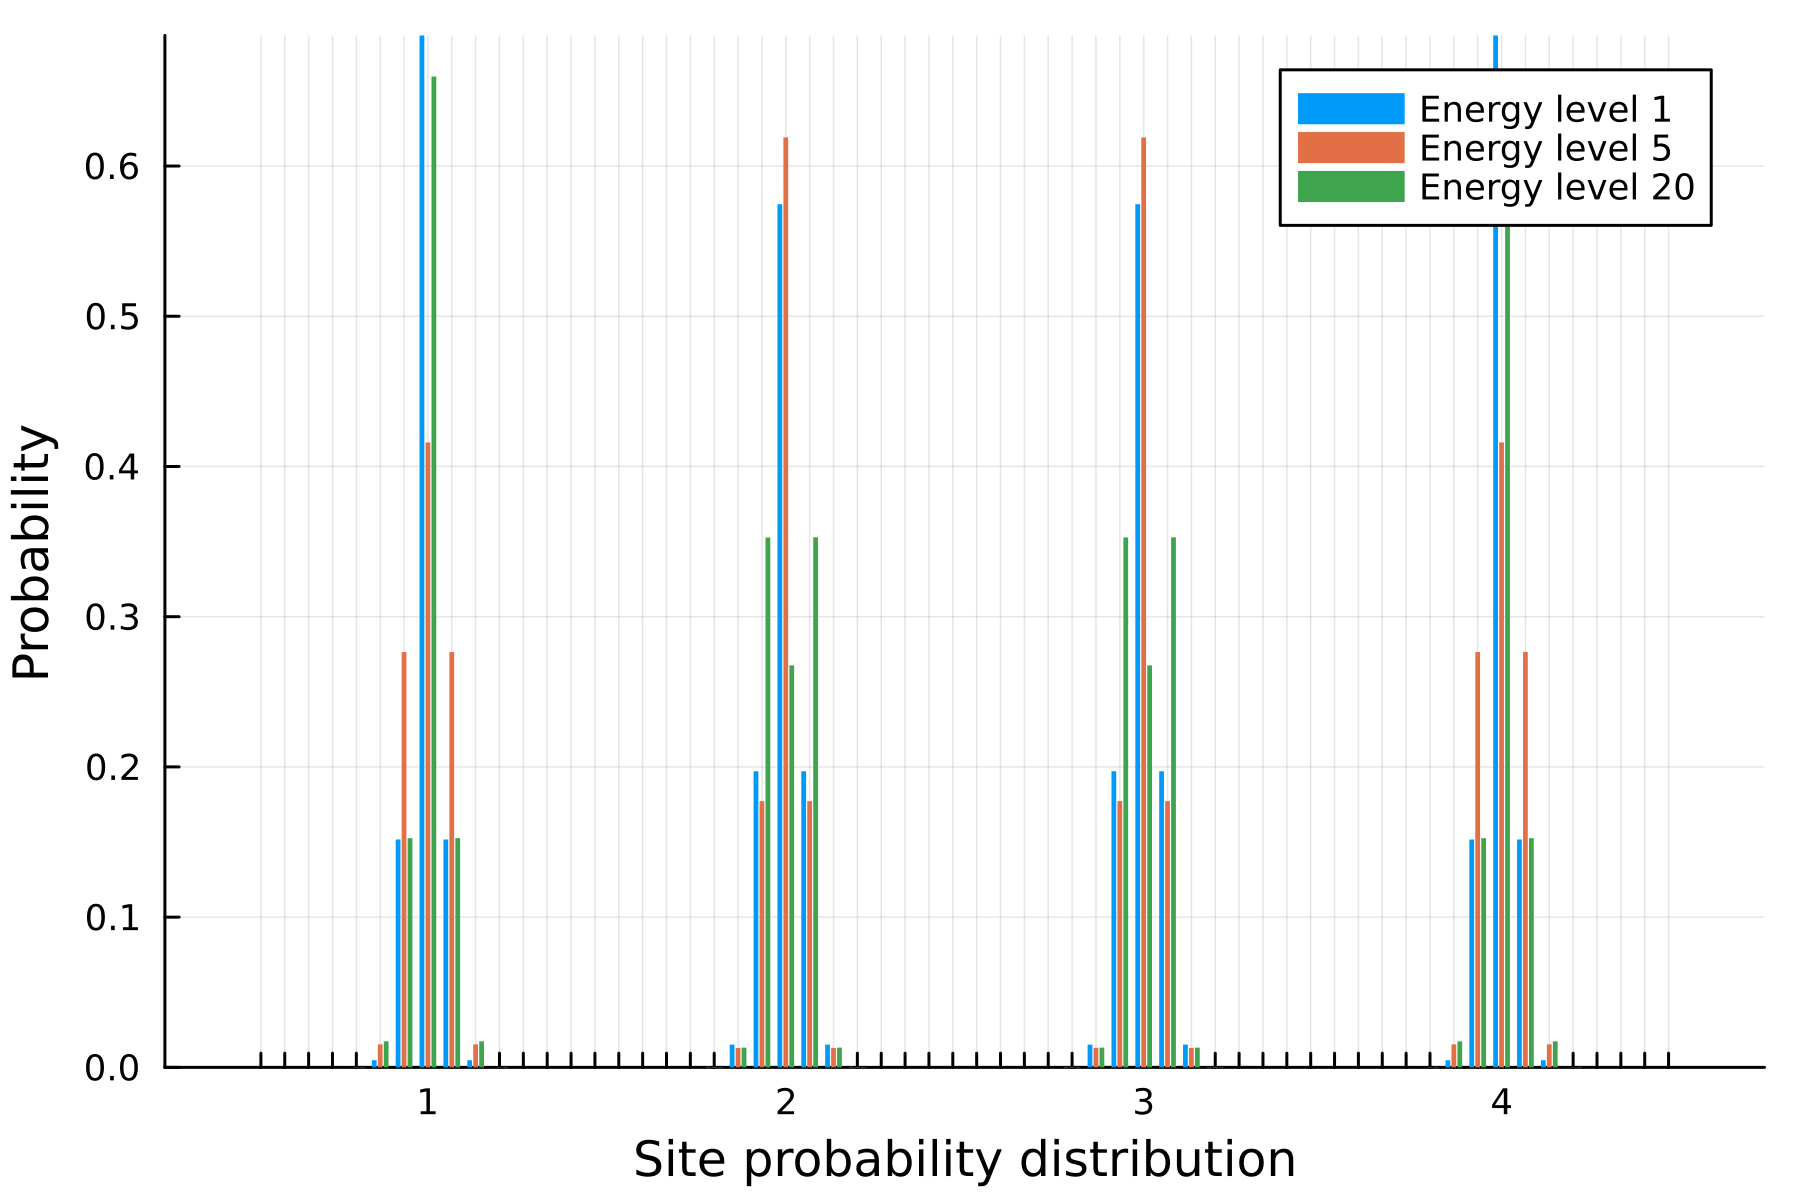

In [182]:
using Plots

data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",
xticks=(1:length(data),[(i-mmax-1)%(2*mmax+1)==0 ? (i ÷ (2*mmax+1))+1 : "" for i=1:length(data)]),dpi=300)
for (i,energy_level) in enumerate([1,5,20])
    data = hist_data[:,:,energy_level]
    bar!(p,float(1:length(data)) .+ (i-2)/4, reshape(data, length(data)), #alpha=0.6, 
    label=string("Energy level ", energy_level), bar_width = 0.2, linecolor=nothing)
end
display(p)
# savefig("2024_05_29_single_site_probability_dist_g=100.png")

# Comparing rotation and M parity symmetries

In [40]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    if (c+d)%2 == 1
        continue
    end 
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2a^2 + 2b^2 == (c^2+d^2) && (a+b)%2 != c%2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    # if !found
    #     println("DIDN'T WORK: c=$c d=$d")
    # end
end

In [44]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2(2a+1)^2 + 2(2b+1)^2 == (2c)^2+(2d)^2 || 2(2a)^2 + 2(2b)^2 == (2c)^2+(2d)^2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    if !found
        println("DIDN'T WORK: c=$c d=$d")
    end
end

c=0 d=0   a=0 b=0
c=1 d=0   a=0 b=0
c=2 d=0   a=1 b=1
c=3 d=0   a=1 b=1
c=4 d=0   a=2 b=2
c=5 d=0   a=3 b=0
c=6 d=0   a=3 b=3
c=7 d=0   a=3 b=3
c=8 d=0   a=4 b=4
c=9 d=0   a=4 b=4
c=10 d=0   a=7 b=1
c=11 d=0   a=5 b=5
c=12 d=0   a=6 b=6
c=13 d=0   a=8 b=3
c=14 d=0   a=7 b=7
c=15 d=0   a=10 b=1
c=16 d=0   a=8 b=8
c=17 d=0   a=11 b=3
c=18 d=0   a=9 b=9
c=19 d=0   a=9 b=9
c=20 d=0   a=14 b=2
c=0 d=1   a=0 b=0
c=1 d=1   a=1 b=0
c=2 d=1   a=1 b=0
c=3 d=1   a=2 b=1
c=4 d=1   a=2 b=1
c=5 d=1   a=3 b=2
c=6 d=1   a=3 b=2
c=7 d=1   a=5 b=0
c=8 d=1   a=5 b=1
c=9 d=1   a=5 b=4
c=10 d=1   a=5 b=4
c=11 d=1   a=6 b=5
c=12 d=1   a=8 b=0
c=13 d=1   a=9 b=2
c=14 d=1   a=7 b=6
c=15 d=1   a=8 b=7
c=16 d=1   a=8 b=7
c=17 d=1   a=12 b=1
c=18 d=1   a=12 b=2
c=19 d=1   a=10 b=9
c=20 d=1   a=10 b=9
c=0 d=2   a=1 b=1
c=1 d=2   a=1 b=0
c=2 d=2   a=2 b=0
c=3 d=2   a=2 b=0
c=4 d=2   a=3 b=1
c=5 d=2   a=3 b=1
c=6 d=2   a=4 b=2
c=7 d=2   a=4 b=2
c=8 d=2   a=5 b=3
c=9 d=2   a=6 b=0
c=10 d=2   a=6 b=4
c=11 d=2   a=7 b

In [43]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2(2a+1)^2 + 2(2b)^2 == (2c+1)^2+(2d+1)^2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    if !found
        println("DIDN'T WORK: c=$c d=$d")
    end
end

c=0 d=0   a=0 b=0
c=1 d=0   a=0 b=1
c=2 d=0   a=1 b=1
c=3 d=0   a=2 b=0
c=4 d=0   a=2 b=2
c=5 d=0   a=2 b=3
c=6 d=0   a=4 b=1
c=7 d=0   a=3 b=4
c=8 d=0   a=4 b=4
c=9 d=0   a=4 b=5
c=10 d=0   a=5 b=5
c=11 d=0   a=5 b=6
c=12 d=0   a=6 b=6
c=13 d=0   a=9 b=1
c=14 d=0   a=7 b=7
c=15 d=0   a=7 b=8
c=16 d=0   a=11 b=2
c=17 d=0   a=8 b=9
c=18 d=0   a=9 b=9
c=19 d=0   a=9 b=10
c=20 d=0   a=14 b=0
c=0 d=1   a=0 b=1
c=1 d=1   a=1 b=0
c=2 d=1   a=0 b=2
c=3 d=1   a=2 b=1
c=4 d=1   a=1 b=3
c=5 d=1   a=3 b=2
c=6 d=1   a=2 b=4
c=7 d=1   a=4 b=3
c=8 d=1   a=3 b=5
c=9 d=1   a=6 b=2
c=10 d=1   a=7 b=0
c=11 d=1   a=6 b=5
c=12 d=1   a=5 b=7
c=13 d=1   a=7 b=6
c=14 d=1   a=9 b=4
c=15 d=1   a=8 b=7
c=16 d=1   a=7 b=9
c=17 d=1   a=9 b=8
c=18 d=1   a=12 b=4
c=19 d=1   a=13 b=3
c=20 d=1   a=14 b=1
c=0 d=2   a=1 b=1
c=1 d=2   a=0 b=2
c=2 d=2   a=2 b=0
c=3 d=2   a=0 b=3
c=4 d=2   a=3 b=1
c=5 d=2   a=1 b=4
c=6 d=2   a=4 b=2
c=7 d=2   a=5 b=1
c=8 d=2   a=5 b=3
c=9 d=2   a=3 b=6
c=10 d=2   a=6 b=4
c=11 d=2   a=4 b=

# Computing symmetries

In [1]:
using LinearAlgebra
using ZChop

function generate_symmetries(H)
    #https://iopscience.iop.org/article/10.1088/1367-2630/aadf67/pdf
    nx, ny = size(H)
    commutations = []
    symmetries = []
    L = []

    # compute all hermitian matrices and their commutations relations with H
    for i=1:nx
        for j=i:nx
            for val in [1, 1im]
                tmp = zeros(ComplexF64, (nx, ny))
                # ensuring zero trace in all hermitian matrices
                if i!=j
                    tmp[i,j] += val
                    tmp[j,i] += conj(val)
                elseif i == 1 || val == 1im # make sure you ignore the complex part when i=j
                    continue
                else
                    tmp[1,1] = -1
                    tmp[i,i] = 1
                end

                comm = tmp*H - H*tmp
                if all(isapprox.(comm,0.0;atol=1e-14))
                    push!(symmetries, tmp) 
                else
                    push!(commutations, comm)
                    push!(L, tmp)
                end
            end
        end
    end

    commutations = reshape(cat(commutations...;dims=3),nx*nx,length(L))
    if length(commutations) == 0
        return symmetries
    end

    # find real superposition of the commutation relations that make the commutation relation 0
    vecs = nullspace(vcat(real.(commutations),imag.(commutations)))
    if length(vecs) == 0
        return []
    end
    new_symmetries = sum(vecs .* L,dims=1)[1,:]
    return [symmetries;new_symmetries]
end
function mutually_commute_symmetries(symmetries)
    # https://iopscience.iop.org/article/10.1088/1367-2630/aadf67/pdf
    A = mapreduce(permutedims, vcat, ([-1im*reshape(a*b-b*a, length(a)) for a in symmetries for b in symmetries]))
    if all(isapprox.(abs.(A),0.0;atol=1e-14))
        return symmetries
    end
    L = mapreduce(permutedims, vcat, map(x->reshape(x, length(x)),symmetries))
    f = (A' \ L' )
    f_reshaped = reshape(f,length(symmetries),length(f)÷length(symmetries))
    K = f_reshaped*f_reshaped'
    l = nullspace(vcat(real.(K), imag.(K)))
    new_symmetries = [sum(vec.*symmetries) for vec in eachcol(l)]
    return new_symmetries
end


mutually_commute_symmetries (generic function with 1 method)

In [23]:
# using Tensorial
# using TensorOperations
using Kronecker

id = Matrix{Float64}(I, 2,2)
Z = [1 0; 0 -1]
X = [0 1; 1 0]
id = Matrix{Float64}(I, 2,2)
# H = Z ⊗ Z ⊗ id + id ⊗ Z ⊗ Z  + id ⊗ X ⊗ id +  id ⊗ id ⊗ X + X ⊗ id ⊗ id 
H = Z ⊗ Z  + id ⊗ X + X ⊗ id
X_sym = X ⊗ X
tmp_sym = generate_symmetries(H)
# sym = mutually_commute_symmetries(tmp_sym)

3-element Vector{Any}:
 ComplexF64[0.03263392268732118 + 0.0im -0.37637715361540325 + 0.0im -0.3763771536154031 - 5.551115123125783e-17im -0.6276270788493776 - 1.373011566974688e-16im; -0.37637715361540325 + 0.0im -0.032633922687321015 + 0.0im 0.19039507375607145 + 1.4429124114947477e-17im -0.3763771536154029 - 5.960368860968747e-18im; -0.3763771536154031 + 5.551115123125783e-17im 0.19039507375607145 - 1.4429124114947477e-17im -0.032633922687321903 + 0.0im -0.37637715361540236 + 7.477856436161365e-17im; -0.6276270788493776 + 1.373011566974688e-16im -0.3763771536154029 + 5.960368860968747e-18im -0.37637715361540236 - 7.477856436161365e-17im 0.03263392268732174 + 0.0im]
 ComplexF64[0.3886344124118929 + 0.0im 0.07689099398033951 + 4.163336342344337e-17im 0.07689099398033972 - 1.1102230246251565e-16im 0.09376432673237631 - 1.9712799347858102e-16im; 0.07689099398033951 - 4.163336342344337e-17im -0.38863441241189234 + 0.0im 0.7172511635954829 + 1.03655008405544e-16im 0.07689099398033916 - 5.

In [22]:
Z ⊗ Z  + id ⊗ X + X ⊗ id

4×4 Matrix{Float64}:
 1.0   1.0   1.0  0.0
 1.0  -1.0   0.0  1.0
 1.0   0.0  -1.0  1.0
 0.0   1.0   1.0  1.0

In [113]:
# H*X_sym - X_sym*H
V = eigvecs(tmp_sym[1])
show(stdout, "text/plain", zchop(inv(V)*H*V))

8×8 Matrix{ComplexF64}:
 2.60388+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im  -0.109916+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im     0.109916+0.0im  6.89973e-14+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im  6.89527e-14+0.0im          1.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im  -3.49396+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im  -1.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im  -2.60388+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im    

In [34]:
_, v = eigen(tmp_sym[1])
a = mapreduce(permutedims, vcat, [diag(inv(v)*s*v) for s in tmp_sym])'
p0 = nullspace(a)
for m in CartesianIndices(Tuple([(-1:2:1) for i in 1:size(a)[1]]))

    # if sum(collect(Tuple(m))) != 0 || m[1] == 1
    #     continue
    # end
    p = a \ (collect(Tuple(m)))
    
    U = exp(1im*π/2* sum(tmp_sym.*p))*1im
    # show(stdout, "text/plain", zchop(U))
    # println()
    # real.(zchop(U))
    # println(zchop(real.(U)))

    # show(stdout, "text/plain", real.(zchop(U)))
    # println()
    # println(m)

    if zchop(U)[2] == 0
        println(eigvals(U))
        show(stdout, "text/plain", real.(zchop(U)))
        println()
        # println(real.(eigvals(U)))
    end
end
# real.(U^4)

ComplexF64[-1.1102230246251565e-16 + 0.9999999999999989im, -8.326672684688674e-17 + 1.0im, 4.17734363090045e-17 + 1.0im, 7.177418381854039e-17 + 0.9999999999999998im]
4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
ComplexF64[-0.7071067811865477 - 0.707106781186547im, 0.707106781186547 + 0.7071067811865481im, 0.7071067811865477 + 0.7071067811865477im, 0.7071067811865479 + 0.7071067811865475im]
4×4 Matrix{Float64}:
 0.707107  0.0       0.0       0.0
 0.0       0.0       0.707107  0.0
 0.0       0.707107  0.0       0.0
 0.0       0.0       0.0       0.707107
ComplexF64[-1.0000000000000004 + 8.326672684688674e-16im, -1.0 + 4.440892098500627e-16im, 0.9999999999999996 + 1.2230808674527723e-15im, 1.0000000000000004 - 1.986531206576165e-16im]
4×4 Matrix{Float64}:
  0.0   0.0   0.0  -1.0
  0.0   0.0  -1.0   0.0
  0.0  -1.0   0.0   0.0
 -1.0   0.0   0.0   0.0
ComplexF64[-0.7071067811865487 + 0.7071067811865461im, -0.7071067811865479 + 0.70710

In [25]:


mmax = 1
Nsites = 2
angle = 0
Estrength = 0
pairs = "nearest"
energies = 20
g = 1
dim = 2*mmax+1
H = Matrix{ComplexF64}(I, (2*mmax+1)^Nsites,(2*mmax+1)^Nsites)
new_hamiltonian(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
for i=1:(2*mmax+1)^Nsites
    H[i,:] = new_hamiltonian(H[i,:])
end
tmp_sym = generate_symmetries(H)
# symmetries = mutually_commute_symmetries(tmp_sym)

20-element Vector{Any}:
 ComplexF64[0.023912644833546493 + 0.0im -0.11546355433142108 - 0.21280069043240168im … -0.11546355433142098 - 0.21280069043240185im -0.18335378942244204 + 0.007726138168080511im; -0.11546355433142108 + 0.21280069043240168im -0.06603310411907344 + 0.0im … 0.07997590274680058 + 1.341158087364569e-16im 0.0693150520000138 - 0.16092631192840018im; … ; -0.11546355433142098 + 0.21280069043240185im 0.07997590274680058 - 1.341158087364569e-16im … -0.06603310411907332 + 0.0im 0.0693150520000138 - 0.16092631192840018im; -0.18335378942244204 - 0.007726138168080511im 0.0693150520000138 + 0.16092631192840018im … 0.0693150520000138 + 0.16092631192840018im 0.15334777470687855 + 0.0im]
 ComplexF64[-0.29937997106918146 + 0.0im 0.02628340650343843 + 0.02204649139141035im … 0.02628340650343808 + 0.022046491391410475im -0.029109697821527305 - 0.03002909021843766im; 0.02628340650343843 - 0.02204649139141035im 0.052650676882666315 + 0.0im … -0.08305606818454178 + 6.877229905347115e-1

In [26]:
A = mapreduce(permutedims, vcat, ([-1im*reshape(a*b-b*a, length(a)) for a in tmp_sym for b in tmp_sym]))
L = mapreduce(permutedims, vcat, map(x->reshape(x, length(x)),tmp_sym))
f = (A' \ L' )
f_reshaped = reshape(f,length(tmp_sym),length(f)÷length(tmp_sym))
K = f_reshaped*f_reshaped'
l = nullspace(vcat(real.(K), imag.(K)))
new_symmetries = [sum(vec.*tmp_sym) for vec in eachcol(l)]

5-element Vector{Matrix{ComplexF64}}:
 [0.09480032955701027 + 0.0im 2.0816681711721685e-17 - 1.2576745200831851e-17im … 7.895323433762418e-17 + 6.591949208711867e-17im 0.3540785782403896 - 6.938893903907228e-18im; 2.0816681711721685e-17 + 1.2576745200831851e-17im -0.11161728094634525 + 0.0im … 0.12869391307523753 - 9.409118657350646e-17im -1.8214596497756474e-17 - 3.0357660829594124e-17im; … ; 7.895323433762418e-17 - 6.591949208711867e-17im 0.12869391307523753 + 9.409118657350646e-17im … -0.11161728094634521 + 0.0im -8.890457814381136e-17 - 5.4643789493269423e-17im; 0.3540785782403896 + 6.938893903907228e-18im -1.8214596497756474e-17 + 3.0357660829594124e-17im … -8.890457814381136e-17 + 5.4643789493269423e-17im 0.09480032955701058 + 0.0im]
 [0.35535141452988367 + 0.0im -6.245004513516506e-17 - 7.025630077706069e-17im … 8.517093970969666e-17 - 1.5352302762394743e-16im 0.13849441342267754 - 1.457167719820518e-16im; -6.245004513516506e-17 + 7.025630077706069e-17im -0.29716916797182447 + 0

In [158]:
H = [
4 1 0 0 0 0 0;
1 2 1 0 0 0 0;
0 1 1 1 0 0 0;
0 0 1 0 1 0 0;
0 0 0 1 1 1 0;
0 0 0 0 1 2 1;
0 0 0 0 0 1 4;
]
s = generate_symmetries(H)
# s = mutually_commute_symmetries(s)
# s[1]*s[6]-s[6]*s[1]
exp(1im*s[2])

7×7 Matrix{ComplexF64}:
    0.898515+0.120744im     …    -0.054583+0.292806im
   0.0132065+0.000102791im     -0.00530945+0.17216im
  -0.0134037+0.0251281im         -0.011791+0.204151im
  -0.0170296+0.128907im         -0.0170296+0.128907im
   -0.011791+0.204151im         -0.0134037+0.0251281im
 -0.00530945+0.17216im      …    0.0132065+0.000102791im
   -0.054583+0.292806im           0.898515+0.120744im

In [188]:
using ZChop
check_all_zero = x-> all(isapprox.(x,0.0;atol=1e-14))
U = exp(1im*symmetries[1])
U

25×25 Matrix{ComplexF64}:
       0.9933+8.50481e-5im   …   0.000151642-0.111217im
 -1.47745e-16-1.7473e-17im       3.53116e-16+1.07343e-16im
   0.00522418+0.00422432im       -0.00466344-0.0143173im
  2.76383e-17+6.54907e-17im      4.58301e-17+1.53777e-17im
   4.87065e-5-0.00114554im        4.87065e-5-0.00114554im
  4.87181e-17-8.45396e-18im  …  -1.11222e-16-1.62268e-16im
  -0.00271582-0.0161859im        -0.00124002+0.00338036im
 -3.14061e-16+3.70664e-18im      3.21255e-16-1.32529e-17im
  -8.36252e-5+0.00451516im       -8.36252e-5+0.00451516im
  2.07038e-16-6.70041e-17im     -2.66441e-19-5.31875e-17im
             ⋮               ⋱  
  -8.36252e-5+0.00451516im       -8.36252e-5+0.00451516im
 -3.71962e-16-1.38723e-17im      3.64021e-16-3.02242e-17im
  -0.00124002+0.00338036im       -0.00271582-0.0161859im
  2.07608e-16+3.98649e-17im     -1.86084e-17+2.61596e-17im
   4.87065e-5-0.00114554im   …    4.87065e-5-0.00114554im
  1.23473e-16+7.01838e-17im     -7.31886e-17-4.82101e-17im
  -0.0046